download the dataset here
https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbUFFZlJNNEpxTUszSWhnclhvREwtajh5VzVMZ3xBQ3Jtc0ttNVdoQl9UdTh2THFzc1loTVBGU1dsUW1nVWw0ajJ4cDRjeHo4MDdXOGhXNFpHaENrV1lpQWZKaG1KZC15elhoaEUyTkdjTFB6NnZTTHhIXzR3eFpRMlBiSkRmVEFMOXRxVlVOcm1PcVlCVzVNZ21taw&q=https%3A%2F%2Fdownload.pytorch.org%2Ftutorial%2Fhymenoptera_data.zip&v=K0lWSB2QoIQ

tutorial from 
https://www.youtube.com/watch?v=K0lWSB2QoIQ&ab_channel=PatrickLoeber

For those new to transfer learning: ideally we would like to freeze all of the layers other than the newly added head layer, and train for n epochs, then unfreeze the preceding layers, and train the entire network using a sliced learning rate, where the parameters of the later layers are updated faster than the parameters of the earlier layers. This is how libraries like fastai handle transfer learning out of the box.

In [1]:
#import libraries
import torch
import torch.nn as nn
import torchvision 
import os
from PIL import Image
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time 
import copy

#create custom dataset classes, may need to do train test split
class Hymenoptera_Dataset(Dataset):
    def __init__(self,root_path,mode=None,train_transforms=None,val_transforms=None):
        #read root_path and find the paths of the train and val folder
        self.train_path=sorted(os.listdir(root_path))[0]
        self.val_path=sorted(os.listdir(root_path))[1]
        self.train_path=os.path.join(root_path,self.train_path)
        self.val_path=os.path.join(root_path,self.val_path)
        #get class names
        self.class_names=os.listdir(self.train_path)
        #create full paths of train_folder_path + respective classes, repeat for val
        self.train_class_paths=[]
        self.val_class_paths=[]
        for class_name in self.class_names:
            train_class_path=os.path.join(self.train_path,class_name)
            val_class_path=os.path.join(self.val_path,class_name)
            self.train_class_paths.append(train_class_path)
            self.val_class_paths.append(val_class_path)
        #get the full paths for all the train images for all classes and store in a list
        self.train_image_paths=[]
        for class_path in self.train_class_paths:
            train_paths=os.listdir(class_path)
            for train_path in train_paths:
                self.train_image_paths.append(os.path.join(class_path,train_path))
        #get the full paths for all the val images for all classes and store in a list
        self.val_image_paths=[]
        for class_path in self.val_class_paths:
            val_paths=os.listdir(class_path)
            for val_path in val_paths:
                self.val_image_paths.append(os.path.join(class_path,val_path))
        #class encoder - use a dictionary to create a mapping of a given class to an assigned int
        self.class_encoder={}
        for i,class_name in enumerate(self.class_names):
            self.class_encoder[class_name]=i
        
        self.mode=mode
        self.train_transforms=train_transforms
        self.val_transforms=val_transforms
        
    def __getitem__(self,index):
        if self.mode=="train":
            image_path=self.train_image_paths[index]
            # Open the image using PIL and convert it to a PyTorch tensor later in the transforms.ToTensor()
            image=Image.open(image_path)
            if image.mode != "RGB":
                image = image.convert("RGB")
            image=self.train_transforms(image)
            class_label=image_path.split("\\")[-2]
            label=label=self.class_encoder[class_label]
            return image,label,class_label
        else:
            image_path=self.val_image_paths[index]
            # Open the image using PIL and convert it to a PyTorch tensor later in the transforms.ToTensor()
            image=Image.open(image_path)
            image=self.val_transforms(image)
            class_label=image_path.split("\\")[-2]
            label=self.class_encoder[class_label]
            return image,label,class_label 
        
    def __len__(self):
        if self.mode=="train":
            return len(self.train_image_paths)
        else:
            return len(self.val_image_paths)
        
# set train and val transforms
img_dim=224
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
def train_transforms():
    t=transforms.Compose([
        transforms.Resize((img_dim,img_dim)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std) 
    ])
    return t

def val_transforms():
    t=transforms.Compose([
        transforms.Resize((img_dim,img_dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std) 
    ])
    return t

#initialise train data and val data from the custom dataset classroot_path="C:/Users/Palaash.HPZ/Downloads/hymenoptera_data"
root_path="C:/Users/Palaash.HPZ/Downloads/hymenoptera_data"

train_data=Hymenoptera_Dataset(
    root_path=root_path,
    mode="train",
    train_transforms=train_transforms(),
)

val_data=Hymenoptera_Dataset(
    root_path=root_path,
    mode="val",
    val_transforms=val_transforms()
)

print(f"len(train_data): {train_data.__len__()}, len(val_data): {val_data.__len__()}")

batch_size=4
#create train and val dataloader
train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

val_dataloader=DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

len(train_data): 245, len(val_data): 153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([4, 3, 224, 224]), labels.shape: torch.Size([4]), class labels are: ('bees', 'ants', 'ants', 'bees')


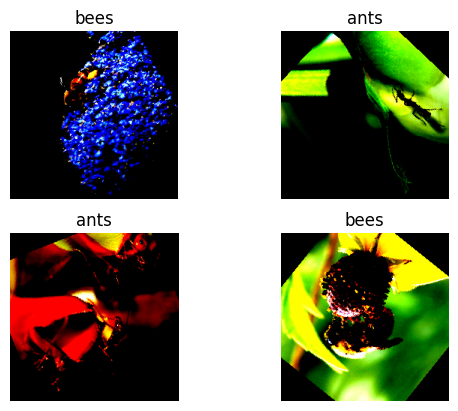

In [68]:
#plot some images with labels
train_iter=iter(train_dataloader)
images,labels,class_labels=next(train_iter)
print(f"images.shape: {images.shape}, labels.shape: {labels.shape}, class labels are: {class_labels}")
# print(images.shape,labels.shape) #batch_size=4 images of 3 RGB channels, img_dim=224, corresponding labels

for i in range(batch_size):
    plt.subplot(int(batch_size/2),int(batch_size/2),i+1)
    img=images[i]
    img=img.numpy()
    img=img.transpose(1,2,0)
    plt.imshow(img)
    plt.title(class_labels[i])
    plt.axis("off")
    
plt.show()

but for BCELoss, does it implement the sigmoid function?
ChatGPT
No, the nn.BCELoss() in PyTorch does not include the sigmoid function. Unlike nn.CrossEntropyLoss(), which combines the softmax activation and the cross-entropy loss, nn.BCELoss() expects the input logits to be passed through a sigmoid activation function before calculating the binary cross-entropy loss.

In [72]:
#create simple custom model for debugging
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(3,6,5) #3 rgb input channels, set 6 output channels, kernel size 5x5
#        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.pool1=nn.MaxPool2d(2,2) #kernel size 2, stride 2
        self.conv2=nn.Conv2d(6,16,5) #input size must be same as previous conv output size
        self.pool2=nn.MaxPool2d(2,2) #kernel size 2, stride 2
        #to get 16*5*5 can print out the diff layers output manualy first
        self.fc1=nn.Linear(16*53*53,1200)
        self.fc2=nn.Linear(1200,84)
#         self.fc3=nn.Linear(84,num_classes)
        self.fc3=nn.Linear(84,1) #1 since using BCELoss, if using CrossEntropyLoss then 2 since its considered multiclass
        self.sigmoid=nn.Sigmoid()

    def forward(self,x):
#         print(1,x.shape)
        out=self.pool1(F.relu(self.conv1(x)))
#         print(2,out.shape)
        out=self.pool2(F.relu(self.conv2(out)))
#         print(3,out.shape)
        #flatten
        out=out.view(-1,16*53*53)
#         print(4,out.shape)
        out=F.relu(self.fc1(out))
#         print(5,out.shape)
        out=F.relu(self.fc2(out))
#         print(6,out.shape)
        out=self.fc3(out)
#         print(7,out.shape)
        predicted_prob=self.sigmoid(out)
        #softmax already included in the loss function so dont need here
        return out
    
num_inputs=img_dim**2
hidden_layers1=4096
hidden_layers2=128
num_classes=len(train_data.class_names)
# model=CustomModel(num_inputs,hidden_layers1,hidden_layers2,num_classes)
model=ConvNet()

criterion=nn.BCELoss()
lr=1e-3
optimizer=torch.optim.Adam(
    model.parameters(),
    lr=lr
)

model

In [3]:
#use pretrained 
model=torchvision.models.resnet18(pretrained=True)
num_input_ftrs=model.fc.in_features #final linear layer
model.fc=nn.Linear(in_features=num_input_ftrs,out_features=1)

lr=1e-3
criterion=nn.BCELoss() #need to implement sigmoid after model(images)
optimizer=torch.optim.Adam(
    model.parameters(),
    lr=lr
)

C:\Users\Palaash.HPZ\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Palaash.HPZ\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
def get_accuracy(outputs,labels): #accuracy function changes with task, this is for binary image classification
    #get num_correct/num_labels
    threshold=0.5
    predicted_classes=[1 if x>=threshold else 0 for x in outputs] #after sigmoid function, output probabilities>=threshold is assigned class 1, else 0
    correct_predictions=[1 if predicted_classes[i]==labels[i] else 0 for i in range(len(labels))]
    num_correct=sum(correct_predictions) #will give number of ones inside since sum+0=sum
    return num_correct/len(labels)*100

In [15]:
num_epochs=1000
print_how_many_training_steps=2

start_time=time.time()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
model.to(device)

#training loop
# to device
# forward pass
# calc loss
# zero grad of optimizer
# calc gradients of loss fn
# update weights of optimizer


#validation loop
# to device
# forward pass
# calc loss

print("########## Start Training loop  ##########")
trg_logs={"loss":[],"acc":[]}
val_logs={"loss":[],"acc":[]}
for epoch in range(num_epochs):
    print("-"*30)
    print(f"Epoch {epoch+1}/{num_epochs}")
    running_training_loss,running_training_acc=[],[]
    running_validation_loss,running_validation_acc=[],[]
    for i,(images,labels,class_names) in enumerate(train_dataloader):
#         print(images.shape,labels.shape,class_names)
#         images=images.reshape((4,3,img_dim**2))
        labels=labels.reshape((-1,1))
#         print(images.shape,labels.shape,class_names)
        images=images.to(device)
        labels=labels.to(device).float()
        outputs=model.forward(images)
        outputs=nn.Sigmoid()(outputs)
#         print(outputs.shape,labels.shape)
#         print(type(outputs),type(labels))
#         print(outputs)
#         print(labels)
        trg_loss=criterion(outputs,labels)
        running_training_loss.append(trg_loss.item())
        optimizer.zero_grad()
        trg_loss.backward()
        optimizer.step()
        trg_acc=get_accuracy(outputs,labels)
        running_training_acc.append(trg_acc)
        
        print_divisor=1/(print_how_many_training_steps+1)
        if i%int(len(train_dataloader)*print_divisor)==0:
            if i==0 or i==len(train_dataloader)-1:
                continue
            else:
                print(f"Step {(i+1)}/{len(train_dataloader)}: training loss: {np.mean(running_training_loss):.4f}, training acc: {np.mean(running_training_acc):.4f}, time elapsed: {(time.time()-start_time):.4f}")

        
    for i,(images,labels,class_names) in enumerate(val_dataloader):
        labels=labels.reshape((-1,1)).float()
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        outputs=nn.Sigmoid()(outputs)
        val_loss=criterion(outputs,labels)
        val_acc=get_accuracy(outputs,labels)
        running_validation_loss.append(val_loss.item())
        running_validation_acc.append(val_acc)

        
    epoch_mean_trg_loss=np.mean(running_training_loss)
    epoch_mean_trg_acc=np.mean(running_training_acc)
    epoch_mean_val_loss=np.mean(running_validation_loss)
    epoch_mean_val_acc=np.mean(running_validation_acc)
    trg_logs["loss"].append(epoch_mean_trg_loss)
    trg_logs["acc"].append(epoch_mean_trg_acc)
    val_logs["loss"].append(epoch_mean_val_loss)
    val_logs["acc"].append(epoch_mean_val_acc)
    print(f"End of epoch {epoch+1}/{num_epochs}")
    print(f"training loss: {epoch_mean_trg_loss:.4f}, training acc: {epoch_mean_trg_acc:.4f}, validation loss: {epoch_mean_val_loss:.4f}, validation acc: {epoch_mean_val_acc:.4f}, time elapsed: {(time.time()-start_time):.4f}")
    
print("-"*30)
print("########## Training loop completed ##########")
print("total time taken: ",time.time()-start_time)

########## Start Training loop  ##########
------------------------------
Epoch 1/1000
Step 21/61: training loss: 0.5632, training acc: 72.6190, time elapsed: 1.1267
Step 41/61: training loss: 0.5853, training acc: 73.7805, time elapsed: 2.0767
End of epoch 1/1000
training loss: 0.5761, training acc: 72.5410, validation loss: 0.8255, validation acc: 53.9474, time elapsed: 4.0610
------------------------------
Epoch 2/1000
Step 21/61: training loss: 0.5111, training acc: 78.5714, time elapsed: 5.0143
Step 41/61: training loss: 0.4970, training acc: 79.2683, time elapsed: 5.9715
End of epoch 2/1000
training loss: 0.5203, training acc: 77.4590, validation loss: 0.9039, validation acc: 50.0000, time elapsed: 7.9858
------------------------------
Epoch 3/1000
Step 21/61: training loss: 0.5318, training acc: 76.1905, time elapsed: 8.8936
Step 41/61: training loss: 0.5212, training acc: 74.3902, time elapsed: 9.7885
End of epoch 3/1000
training loss: 0.5174, training acc: 74.1803, validation 

Step 21/61: training loss: 0.3972, training acc: 84.5238, time elapsed: 93.7934
Step 41/61: training loss: 0.5882, training acc: 73.7805, time elapsed: 94.7373
End of epoch 25/1000
training loss: 0.5629, training acc: 74.1803, validation loss: 0.8134, validation acc: 52.6316, time elapsed: 96.7954
------------------------------
Epoch 26/1000
Step 21/61: training loss: 0.4586, training acc: 79.7619, time elapsed: 97.7625
Step 41/61: training loss: 0.4342, training acc: 81.0976, time elapsed: 98.7396
End of epoch 26/1000
training loss: 0.4391, training acc: 80.7377, validation loss: 1.0376, validation acc: 48.6842, time elapsed: 100.6197
------------------------------
Epoch 27/1000
Step 21/61: training loss: 0.5579, training acc: 77.3810, time elapsed: 101.5353
Step 41/61: training loss: 0.4998, training acc: 79.8780, time elapsed: 102.3962
End of epoch 27/1000
training loss: 0.4802, training acc: 80.7377, validation loss: 0.9197, validation acc: 56.5789, time elapsed: 104.3021
---------

Step 21/61: training loss: 0.4740, training acc: 78.5714, time elapsed: 185.5583
Step 41/61: training loss: 0.4696, training acc: 78.6585, time elapsed: 186.4902
End of epoch 49/1000
training loss: 0.4584, training acc: 78.2787, validation loss: 0.9135, validation acc: 53.2895, time elapsed: 188.5207
------------------------------
Epoch 50/1000
Step 21/61: training loss: 0.4939, training acc: 79.7619, time elapsed: 189.5267
Step 41/61: training loss: 0.4797, training acc: 79.8780, time elapsed: 190.4152
End of epoch 50/1000
training loss: 0.4847, training acc: 78.2787, validation loss: 0.9329, validation acc: 54.6053, time elapsed: 192.4389
------------------------------
Epoch 51/1000
Step 21/61: training loss: 0.4644, training acc: 78.5714, time elapsed: 193.4099
Step 41/61: training loss: 0.4793, training acc: 78.0488, time elapsed: 194.3409
End of epoch 51/1000
training loss: 0.5069, training acc: 75.8197, validation loss: 0.8536, validation acc: 51.3158, time elapsed: 196.2634
----

Step 21/61: training loss: 0.4979, training acc: 77.3810, time elapsed: 278.3247
Step 41/61: training loss: 0.4711, training acc: 79.8780, time elapsed: 279.1678
End of epoch 73/1000
training loss: 0.4848, training acc: 79.5082, validation loss: 0.8652, validation acc: 51.3158, time elapsed: 281.1014
------------------------------
Epoch 74/1000
Step 21/61: training loss: 0.4622, training acc: 77.3810, time elapsed: 282.1144
Step 41/61: training loss: 0.4291, training acc: 80.4878, time elapsed: 282.9894
End of epoch 74/1000
training loss: 0.4435, training acc: 80.7377, validation loss: 1.1365, validation acc: 50.0000, time elapsed: 284.8593
------------------------------
Epoch 75/1000
Step 21/61: training loss: 0.4393, training acc: 78.5714, time elapsed: 285.8318
Step 41/61: training loss: 0.4184, training acc: 82.3171, time elapsed: 286.6864
End of epoch 75/1000
training loss: 0.4303, training acc: 80.3279, validation loss: 0.9840, validation acc: 50.0000, time elapsed: 288.7616
----

Step 21/61: training loss: 0.3829, training acc: 84.5238, time elapsed: 371.2209
Step 41/61: training loss: 0.4038, training acc: 83.5366, time elapsed: 372.1269
End of epoch 97/1000
training loss: 0.3770, training acc: 84.0164, validation loss: 0.8793, validation acc: 58.5526, time elapsed: 374.1651
------------------------------
Epoch 98/1000
Step 21/61: training loss: 0.3364, training acc: 83.3333, time elapsed: 375.1137
Step 41/61: training loss: 0.3955, training acc: 80.4878, time elapsed: 376.0136
End of epoch 98/1000
training loss: 0.4082, training acc: 80.3279, validation loss: 0.8656, validation acc: 60.5263, time elapsed: 378.0904
------------------------------
Epoch 99/1000
Step 21/61: training loss: 0.4153, training acc: 80.9524, time elapsed: 378.9615
Step 41/61: training loss: 0.3693, training acc: 84.7561, time elapsed: 379.8530
End of epoch 99/1000
training loss: 0.3410, training acc: 86.0656, validation loss: 0.8776, validation acc: 66.4474, time elapsed: 381.9115
----

Step 21/61: training loss: 0.2826, training acc: 86.9048, time elapsed: 465.0283
Step 41/61: training loss: 0.2790, training acc: 86.5854, time elapsed: 466.0056
End of epoch 121/1000
training loss: 0.2877, training acc: 86.8852, validation loss: 0.9702, validation acc: 62.5000, time elapsed: 468.0666
------------------------------
Epoch 122/1000
Step 21/61: training loss: 0.2451, training acc: 90.4762, time elapsed: 469.1027
Step 41/61: training loss: 0.2900, training acc: 88.4146, time elapsed: 470.0832
End of epoch 122/1000
training loss: 0.3063, training acc: 87.7049, validation loss: 1.0903, validation acc: 61.1842, time elapsed: 472.0344
------------------------------
Epoch 123/1000
Step 21/61: training loss: 0.1915, training acc: 90.4762, time elapsed: 472.9712
Step 41/61: training loss: 0.2616, training acc: 87.8049, time elapsed: 473.8546
End of epoch 123/1000
training loss: 0.2522, training acc: 88.1148, validation loss: 0.9598, validation acc: 59.2105, time elapsed: 476.0989

Step 21/61: training loss: 0.2468, training acc: 88.0952, time elapsed: 559.7115
Step 41/61: training loss: 0.2334, training acc: 90.2439, time elapsed: 560.6235
End of epoch 145/1000
training loss: 0.2347, training acc: 90.5738, validation loss: 0.9047, validation acc: 67.1053, time elapsed: 562.6967
------------------------------
Epoch 146/1000
Step 21/61: training loss: 0.3075, training acc: 82.1429, time elapsed: 563.7164
Step 41/61: training loss: 0.2737, training acc: 86.5854, time elapsed: 564.6316
End of epoch 146/1000
training loss: 0.2662, training acc: 87.2951, validation loss: 0.9586, validation acc: 63.8158, time elapsed: 566.6302
------------------------------
Epoch 147/1000
Step 21/61: training loss: 0.2896, training acc: 88.0952, time elapsed: 567.5588
Step 41/61: training loss: 0.2591, training acc: 89.0244, time elapsed: 568.4979
End of epoch 147/1000
training loss: 0.2581, training acc: 89.3443, validation loss: 0.8880, validation acc: 65.1316, time elapsed: 570.5290

Step 21/61: training loss: 0.1879, training acc: 90.4762, time elapsed: 654.5694
Step 41/61: training loss: 0.1707, training acc: 92.6829, time elapsed: 655.4662
End of epoch 169/1000
training loss: 0.1780, training acc: 92.6230, validation loss: 1.0887, validation acc: 66.4474, time elapsed: 657.4332
------------------------------
Epoch 170/1000
Step 21/61: training loss: 0.2367, training acc: 90.4762, time elapsed: 658.3793
Step 41/61: training loss: 0.2443, training acc: 92.0732, time elapsed: 659.2583
End of epoch 170/1000
training loss: 0.2333, training acc: 92.2131, validation loss: 1.1765, validation acc: 64.4737, time elapsed: 661.2372
------------------------------
Epoch 171/1000
Step 21/61: training loss: 0.2132, training acc: 90.4762, time elapsed: 662.2135
Step 41/61: training loss: 0.2031, training acc: 91.4634, time elapsed: 663.2134
End of epoch 171/1000
training loss: 0.1901, training acc: 92.2131, validation loss: 0.9378, validation acc: 68.4211, time elapsed: 665.2061

Step 21/61: training loss: 0.2195, training acc: 91.6667, time elapsed: 747.9490
Step 41/61: training loss: 0.1747, training acc: 92.6829, time elapsed: 748.8647
End of epoch 193/1000
training loss: 0.1787, training acc: 92.2131, validation loss: 1.0520, validation acc: 66.4474, time elapsed: 751.0331
------------------------------
Epoch 194/1000
Step 21/61: training loss: 0.1232, training acc: 94.0476, time elapsed: 751.9963
Step 41/61: training loss: 0.1859, training acc: 89.6341, time elapsed: 752.9540
End of epoch 194/1000
training loss: 0.1649, training acc: 90.9836, validation loss: 1.1140, validation acc: 65.1316, time elapsed: 754.9959
------------------------------
Epoch 195/1000
Step 21/61: training loss: 0.1280, training acc: 95.2381, time elapsed: 755.9341
Step 41/61: training loss: 0.1300, training acc: 95.1220, time elapsed: 756.9117
End of epoch 195/1000
training loss: 0.1914, training acc: 93.4426, validation loss: 0.8385, validation acc: 67.7632, time elapsed: 758.9485

Step 21/61: training loss: 0.1625, training acc: 91.6667, time elapsed: 843.3356
Step 41/61: training loss: 0.1436, training acc: 93.2927, time elapsed: 844.2502
End of epoch 217/1000
training loss: 0.1490, training acc: 93.4426, validation loss: 1.1664, validation acc: 67.1053, time elapsed: 846.1330
------------------------------
Epoch 218/1000
Step 21/61: training loss: 0.2344, training acc: 91.6667, time elapsed: 847.1388
Step 41/61: training loss: 0.2753, training acc: 86.5854, time elapsed: 848.0565
End of epoch 218/1000
training loss: 0.2463, training acc: 88.1148, validation loss: 1.1496, validation acc: 67.7632, time elapsed: 850.0188
------------------------------
Epoch 219/1000
Step 21/61: training loss: 0.1205, training acc: 95.2381, time elapsed: 851.0454
Step 41/61: training loss: 0.1628, training acc: 93.2927, time elapsed: 852.0386
End of epoch 219/1000
training loss: 0.1596, training acc: 93.4426, validation loss: 1.0099, validation acc: 68.4211, time elapsed: 853.9809

Step 21/61: training loss: 0.1413, training acc: 94.0476, time elapsed: 936.8083
Step 41/61: training loss: 0.1176, training acc: 95.7317, time elapsed: 937.7254
End of epoch 241/1000
training loss: 0.1225, training acc: 94.2623, validation loss: 1.1343, validation acc: 72.3684, time elapsed: 939.7728
------------------------------
Epoch 242/1000
Step 21/61: training loss: 0.1823, training acc: 95.2381, time elapsed: 940.7012
Step 41/61: training loss: 0.1456, training acc: 95.1220, time elapsed: 941.6637
End of epoch 242/1000
training loss: 0.1784, training acc: 93.4426, validation loss: 1.6563, validation acc: 66.4474, time elapsed: 943.6550
------------------------------
Epoch 243/1000
Step 21/61: training loss: 0.3773, training acc: 86.9048, time elapsed: 944.6283
Step 41/61: training loss: 0.2768, training acc: 89.6341, time elapsed: 945.6798
End of epoch 243/1000
training loss: 0.2526, training acc: 89.7541, validation loss: 0.8814, validation acc: 73.0263, time elapsed: 947.6170

End of epoch 264/1000
training loss: 0.0968, training acc: 96.7213, validation loss: 1.0068, validation acc: 72.3684, time elapsed: 1030.5466
------------------------------
Epoch 265/1000
Step 21/61: training loss: 0.1243, training acc: 95.2381, time elapsed: 1031.5390
Step 41/61: training loss: 0.1371, training acc: 94.5122, time elapsed: 1032.5074
End of epoch 265/1000
training loss: 0.1069, training acc: 95.9016, validation loss: 1.0953, validation acc: 69.0789, time elapsed: 1034.4914
------------------------------
Epoch 266/1000
Step 21/61: training loss: 0.0777, training acc: 98.8095, time elapsed: 1035.5108
Step 41/61: training loss: 0.0847, training acc: 98.1707, time elapsed: 1036.4768
End of epoch 266/1000
training loss: 0.1637, training acc: 95.4918, validation loss: 1.5831, validation acc: 68.4211, time elapsed: 1038.5068
------------------------------
Epoch 267/1000
Step 21/61: training loss: 0.2390, training acc: 89.2857, time elapsed: 1039.5690
Step 41/61: training loss:

Step 21/61: training loss: 0.1659, training acc: 96.4286, time elapsed: 1120.9030
Step 41/61: training loss: 0.1565, training acc: 94.5122, time elapsed: 1121.8720
End of epoch 288/1000
training loss: 0.1341, training acc: 95.4918, validation loss: 1.1573, validation acc: 64.4737, time elapsed: 1123.8899
------------------------------
Epoch 289/1000
Step 21/61: training loss: 0.0877, training acc: 98.8095, time elapsed: 1124.8639
Step 41/61: training loss: 0.0641, training acc: 98.7805, time elapsed: 1125.7657
End of epoch 289/1000
training loss: 0.1232, training acc: 97.1311, validation loss: 1.2187, validation acc: 67.1053, time elapsed: 1127.8677
------------------------------
Epoch 290/1000
Step 21/61: training loss: 0.1280, training acc: 96.4286, time elapsed: 1128.7924
Step 41/61: training loss: 0.1001, training acc: 96.9512, time elapsed: 1129.8132
End of epoch 290/1000
training loss: 0.1978, training acc: 92.2131, validation loss: 0.9195, validation acc: 71.0526, time elapsed: 

End of epoch 311/1000
training loss: 0.0979, training acc: 95.4918, validation loss: 1.4192, validation acc: 65.7895, time elapsed: 1213.5357
------------------------------
Epoch 312/1000
Step 21/61: training loss: 0.1287, training acc: 94.0476, time elapsed: 1214.4531
Step 41/61: training loss: 0.0789, training acc: 96.3415, time elapsed: 1215.3242
End of epoch 312/1000
training loss: 0.0728, training acc: 97.1311, validation loss: 1.1724, validation acc: 69.0789, time elapsed: 1217.3483
------------------------------
Epoch 313/1000
Step 21/61: training loss: 0.0883, training acc: 96.4286, time elapsed: 1218.3209
Step 41/61: training loss: 0.1273, training acc: 95.7317, time elapsed: 1219.1857
End of epoch 313/1000
training loss: 0.1272, training acc: 95.0820, validation loss: 0.7574, validation acc: 76.3158, time elapsed: 1221.2554
------------------------------
Epoch 314/1000
Step 21/61: training loss: 0.0436, training acc: 100.0000, time elapsed: 1222.2954
Step 41/61: training loss

Step 21/61: training loss: 0.1368, training acc: 94.0476, time elapsed: 1304.7732
Step 41/61: training loss: 0.1422, training acc: 94.5122, time elapsed: 1305.7105
End of epoch 335/1000
training loss: 0.1743, training acc: 93.4426, validation loss: 1.0477, validation acc: 71.0526, time elapsed: 1307.7097
------------------------------
Epoch 336/1000
Step 21/61: training loss: 0.1466, training acc: 94.0476, time elapsed: 1308.6666
Step 41/61: training loss: 0.1677, training acc: 92.6829, time elapsed: 1309.5289
End of epoch 336/1000
training loss: 0.1434, training acc: 94.6721, validation loss: 0.9496, validation acc: 73.0263, time elapsed: 1311.4430
------------------------------
Epoch 337/1000
Step 21/61: training loss: 0.0553, training acc: 98.8095, time elapsed: 1312.4435
Step 41/61: training loss: 0.0466, training acc: 99.3902, time elapsed: 1313.3452
End of epoch 337/1000
training loss: 0.0508, training acc: 99.1803, validation loss: 1.0903, validation acc: 71.0526, time elapsed: 

End of epoch 358/1000
training loss: 0.0594, training acc: 97.1311, validation loss: 1.3485, validation acc: 72.3684, time elapsed: 1397.0458
------------------------------
Epoch 359/1000
Step 21/61: training loss: 0.0690, training acc: 95.2381, time elapsed: 1398.0204
Step 41/61: training loss: 0.0781, training acc: 95.7317, time elapsed: 1398.9076
End of epoch 359/1000
training loss: 0.1043, training acc: 94.6721, validation loss: 1.0465, validation acc: 73.6842, time elapsed: 1400.9295
------------------------------
Epoch 360/1000
Step 21/61: training loss: 0.0218, training acc: 98.8095, time elapsed: 1401.9023
Step 41/61: training loss: 0.0848, training acc: 96.9512, time elapsed: 1402.8517
End of epoch 360/1000
training loss: 0.0795, training acc: 97.1311, validation loss: 0.9145, validation acc: 74.3421, time elapsed: 1404.8732
------------------------------
Epoch 361/1000
Step 21/61: training loss: 0.0861, training acc: 95.2381, time elapsed: 1405.8544
Step 41/61: training loss:

Step 21/61: training loss: 0.1416, training acc: 95.2381, time elapsed: 1485.5085
Step 41/61: training loss: 0.1251, training acc: 96.3415, time elapsed: 1486.4464
End of epoch 382/1000
training loss: 0.0924, training acc: 97.1311, validation loss: 1.2786, validation acc: 71.7105, time elapsed: 1488.4634
------------------------------
Epoch 383/1000
Step 21/61: training loss: 0.0330, training acc: 100.0000, time elapsed: 1489.4042
Step 41/61: training loss: 0.0233, training acc: 100.0000, time elapsed: 1490.3196
End of epoch 383/1000
training loss: 0.0303, training acc: 99.5902, validation loss: 1.2890, validation acc: 71.7105, time elapsed: 1492.2647
------------------------------
Epoch 384/1000
Step 21/61: training loss: 0.0145, training acc: 100.0000, time elapsed: 1493.1844
Step 41/61: training loss: 0.0301, training acc: 98.7805, time elapsed: 1494.0332
End of epoch 384/1000
training loss: 0.0367, training acc: 98.3607, validation loss: 1.1583, validation acc: 69.7368, time elapse

End of epoch 405/1000
training loss: 0.0738, training acc: 97.9508, validation loss: 1.0686, validation acc: 71.0526, time elapsed: 1576.0944
------------------------------
Epoch 406/1000
Step 21/61: training loss: 0.0815, training acc: 95.2381, time elapsed: 1577.0332
Step 41/61: training loss: 0.0544, training acc: 97.5610, time elapsed: 1577.9448
End of epoch 406/1000
training loss: 0.0423, training acc: 98.3607, validation loss: 1.2644, validation acc: 73.0263, time elapsed: 1579.9121
------------------------------
Epoch 407/1000
Step 21/61: training loss: 0.0220, training acc: 98.8095, time elapsed: 1580.7980
Step 41/61: training loss: 0.0172, training acc: 99.3902, time elapsed: 1581.7340
End of epoch 407/1000
training loss: 0.0272, training acc: 99.1803, validation loss: 1.1792, validation acc: 71.7105, time elapsed: 1583.6094
------------------------------
Epoch 408/1000
Step 21/61: training loss: 0.0491, training acc: 96.4286, time elapsed: 1584.5145
Step 41/61: training loss:

Step 21/61: training loss: 0.0826, training acc: 97.6190, time elapsed: 1665.6662
Step 41/61: training loss: 0.0768, training acc: 97.5610, time elapsed: 1666.5862
End of epoch 429/1000
training loss: 0.0650, training acc: 97.9508, validation loss: 1.1502, validation acc: 73.0263, time elapsed: 1668.4996
------------------------------
Epoch 430/1000
Step 21/61: training loss: 0.0582, training acc: 98.8095, time elapsed: 1669.4932
Step 41/61: training loss: 0.0409, training acc: 99.3902, time elapsed: 1670.3974
End of epoch 430/1000
training loss: 0.0317, training acc: 99.5902, validation loss: 1.3366, validation acc: 71.7105, time elapsed: 1672.4027
------------------------------
Epoch 431/1000
Step 21/61: training loss: 0.0322, training acc: 98.8095, time elapsed: 1673.2942
Step 41/61: training loss: 0.0636, training acc: 98.7805, time elapsed: 1674.1626
End of epoch 431/1000
training loss: 0.0643, training acc: 97.9508, validation loss: 1.5433, validation acc: 69.7368, time elapsed: 

End of epoch 452/1000
training loss: 0.0565, training acc: 96.7213, validation loss: 1.7628, validation acc: 68.4211, time elapsed: 1757.8706
------------------------------
Epoch 453/1000
Step 21/61: training loss: 0.1375, training acc: 95.2381, time elapsed: 1758.9462
Step 41/61: training loss: 0.2204, training acc: 95.1220, time elapsed: 1759.8572
End of epoch 453/1000
training loss: 0.1902, training acc: 95.0820, validation loss: 1.4581, validation acc: 69.0789, time elapsed: 1761.7574
------------------------------
Epoch 454/1000
Step 21/61: training loss: 0.0332, training acc: 98.8095, time elapsed: 1762.7272
Step 41/61: training loss: 0.0309, training acc: 99.3902, time elapsed: 1763.6052
End of epoch 454/1000
training loss: 0.0965, training acc: 97.5410, validation loss: 1.3169, validation acc: 67.1053, time elapsed: 1765.5752
------------------------------
Epoch 455/1000
Step 21/61: training loss: 0.0492, training acc: 97.6190, time elapsed: 1766.4780
Step 41/61: training loss:

Step 21/61: training loss: 0.0350, training acc: 98.8095, time elapsed: 1848.0062
Step 41/61: training loss: 0.0636, training acc: 97.5610, time elapsed: 1848.8778
End of epoch 476/1000
training loss: 0.0551, training acc: 97.9508, validation loss: 1.2399, validation acc: 75.0000, time elapsed: 1850.8133
------------------------------
Epoch 477/1000
Step 21/61: training loss: 0.0533, training acc: 98.8095, time elapsed: 1851.7593
Step 41/61: training loss: 0.0473, training acc: 98.7805, time elapsed: 1852.7038
End of epoch 477/1000
training loss: 0.0476, training acc: 98.3607, validation loss: 0.9996, validation acc: 76.3158, time elapsed: 1854.6387
------------------------------
Epoch 478/1000
Step 21/61: training loss: 0.0666, training acc: 96.4286, time elapsed: 1855.6317
Step 41/61: training loss: 0.0763, training acc: 96.9512, time elapsed: 1856.5420
End of epoch 478/1000
training loss: 0.0741, training acc: 97.5410, validation loss: 1.1215, validation acc: 71.0526, time elapsed: 

End of epoch 499/1000
training loss: 0.0403, training acc: 97.9508, validation loss: 1.0414, validation acc: 74.3421, time elapsed: 1940.8403
------------------------------
Epoch 500/1000
Step 21/61: training loss: 0.0849, training acc: 96.4286, time elapsed: 1941.9117
Step 41/61: training loss: 0.0630, training acc: 97.5610, time elapsed: 1942.7833
End of epoch 500/1000
training loss: 0.0477, training acc: 98.3607, validation loss: 1.0580, validation acc: 73.6842, time elapsed: 1944.8566
------------------------------
Epoch 501/1000
Step 21/61: training loss: 0.0194, training acc: 100.0000, time elapsed: 1945.9086
Step 41/61: training loss: 0.0132, training acc: 100.0000, time elapsed: 1946.7984
End of epoch 501/1000
training loss: 0.0266, training acc: 99.1803, validation loss: 1.2134, validation acc: 72.3684, time elapsed: 1948.7637
------------------------------
Epoch 502/1000
Step 21/61: training loss: 0.0057, training acc: 100.0000, time elapsed: 1949.7825
Step 41/61: training lo

Step 21/61: training loss: 0.1007, training acc: 94.0476, time elapsed: 2033.8368
Step 41/61: training loss: 0.0584, training acc: 96.9512, time elapsed: 2034.9456
End of epoch 523/1000
training loss: 0.0782, training acc: 97.1311, validation loss: 1.0361, validation acc: 73.6842, time elapsed: 2037.2436
------------------------------
Epoch 524/1000
Step 21/61: training loss: 0.0595, training acc: 98.8095, time elapsed: 2038.3332
Step 41/61: training loss: 0.0472, training acc: 98.7805, time elapsed: 2039.3852
End of epoch 524/1000
training loss: 0.0371, training acc: 99.1803, validation loss: 0.9424, validation acc: 75.0000, time elapsed: 2041.6321
------------------------------
Epoch 525/1000
Step 21/61: training loss: 0.0506, training acc: 98.8095, time elapsed: 2042.7183
Step 41/61: training loss: 0.0350, training acc: 98.7805, time elapsed: 2043.8171
End of epoch 525/1000
training loss: 0.0280, training acc: 99.1803, validation loss: 1.0556, validation acc: 75.6579, time elapsed: 

End of epoch 546/1000
training loss: 0.0443, training acc: 98.3607, validation loss: 1.1264, validation acc: 65.7895, time elapsed: 2137.2682
------------------------------
Epoch 547/1000
Step 21/61: training loss: 0.0436, training acc: 98.8095, time elapsed: 2138.4178
Step 41/61: training loss: 0.0774, training acc: 97.5610, time elapsed: 2139.3754
End of epoch 547/1000
training loss: 0.0848, training acc: 97.5410, validation loss: 1.4283, validation acc: 68.4211, time elapsed: 2141.5960
------------------------------
Epoch 548/1000
Step 21/61: training loss: 0.1073, training acc: 96.4286, time elapsed: 2142.5691
Step 41/61: training loss: 0.0895, training acc: 97.5610, time elapsed: 2143.6284
End of epoch 548/1000
training loss: 0.0825, training acc: 97.5410, validation loss: 1.1845, validation acc: 71.7105, time elapsed: 2145.7965
------------------------------
Epoch 549/1000
Step 21/61: training loss: 0.0848, training acc: 96.4286, time elapsed: 2146.7702
Step 41/61: training loss:

Step 21/61: training loss: 0.0247, training acc: 98.8095, time elapsed: 2237.7795
Step 41/61: training loss: 0.0588, training acc: 96.3415, time elapsed: 2238.6982
End of epoch 570/1000
training loss: 0.0591, training acc: 96.7213, validation loss: 1.5244, validation acc: 67.7632, time elapsed: 2241.1455
------------------------------
Epoch 571/1000
Step 21/61: training loss: 0.1001, training acc: 97.6190, time elapsed: 2242.2573
Step 41/61: training loss: 0.1066, training acc: 96.9512, time elapsed: 2243.2784
End of epoch 571/1000
training loss: 0.0947, training acc: 96.7213, validation loss: 0.7764, validation acc: 78.2895, time elapsed: 2245.6134
------------------------------
Epoch 572/1000
Step 21/61: training loss: 0.0936, training acc: 97.6190, time elapsed: 2246.5436
Step 41/61: training loss: 0.0711, training acc: 97.5610, time elapsed: 2247.4777
End of epoch 572/1000
training loss: 0.0618, training acc: 97.5410, validation loss: 0.8356, validation acc: 79.6053, time elapsed: 

Step 41/61: training loss: 0.0592, training acc: 97.5610, time elapsed: 2336.8340
End of epoch 593/1000
training loss: 0.0483, training acc: 98.3607, validation loss: 2.8251, validation acc: 72.3684, time elapsed: 2339.0770
------------------------------
Epoch 594/1000
Step 21/61: training loss: 0.1041, training acc: 96.4286, time elapsed: 2340.2030
Step 41/61: training loss: 0.1470, training acc: 95.1220, time elapsed: 2341.2143
End of epoch 594/1000
training loss: 0.2406, training acc: 91.8033, validation loss: 1.5389, validation acc: 67.1053, time elapsed: 2343.3102
------------------------------
Epoch 595/1000
Step 21/61: training loss: 0.0303, training acc: 100.0000, time elapsed: 2344.6037
Step 41/61: training loss: 0.0409, training acc: 98.7805, time elapsed: 2345.6644
End of epoch 595/1000
training loss: 0.0515, training acc: 97.9508, validation loss: 1.0053, validation acc: 75.6579, time elapsed: 2348.0250
------------------------------
Epoch 596/1000
Step 21/61: training loss

End of epoch 616/1000
training loss: 0.0592, training acc: 97.5410, validation loss: 0.8500, validation acc: 76.9737, time elapsed: 2437.2670
------------------------------
Epoch 617/1000
Step 21/61: training loss: 0.0236, training acc: 98.8095, time elapsed: 2438.2056
Step 41/61: training loss: 0.0630, training acc: 96.3415, time elapsed: 2439.1867
End of epoch 617/1000
training loss: 0.0475, training acc: 97.1311, validation loss: 1.2115, validation acc: 74.3421, time elapsed: 2441.3815
------------------------------
Epoch 618/1000
Step 21/61: training loss: 0.0111, training acc: 100.0000, time elapsed: 2442.3956
Step 41/61: training loss: 0.0630, training acc: 97.5610, time elapsed: 2443.4231
End of epoch 618/1000
training loss: 0.0758, training acc: 97.5410, validation loss: 1.2139, validation acc: 71.0526, time elapsed: 2445.6194
------------------------------
Epoch 619/1000
Step 21/61: training loss: 0.0620, training acc: 96.4286, time elapsed: 2446.8227
Step 41/61: training loss

Step 21/61: training loss: 0.0420, training acc: 98.8095, time elapsed: 2535.8683
Step 41/61: training loss: 0.0320, training acc: 99.3902, time elapsed: 2537.0691
End of epoch 640/1000
training loss: 0.0240, training acc: 99.5902, validation loss: 1.6826, validation acc: 73.6842, time elapsed: 2539.1592
------------------------------
Epoch 641/1000
Step 21/61: training loss: 0.0324, training acc: 98.8095, time elapsed: 2540.2672
Step 41/61: training loss: 0.0620, training acc: 98.1707, time elapsed: 2541.2156
End of epoch 641/1000
training loss: 0.0666, training acc: 97.9508, validation loss: 1.2024, validation acc: 73.6842, time elapsed: 2543.4864
------------------------------
Epoch 642/1000
Step 21/61: training loss: 0.0312, training acc: 98.8095, time elapsed: 2544.4737
Step 41/61: training loss: 0.0859, training acc: 98.1707, time elapsed: 2545.4030
End of epoch 642/1000
training loss: 0.0640, training acc: 98.7705, validation loss: 1.3885, validation acc: 71.0526, time elapsed: 

End of epoch 663/1000
training loss: 0.0286, training acc: 99.1803, validation loss: 1.6966, validation acc: 69.7368, time elapsed: 2635.0826
------------------------------
Epoch 664/1000
Step 21/61: training loss: 0.0870, training acc: 97.6190, time elapsed: 2635.9859
Step 41/61: training loss: 0.0522, training acc: 98.1707, time elapsed: 2636.9274
End of epoch 664/1000
training loss: 0.0458, training acc: 97.9508, validation loss: 1.0353, validation acc: 77.6316, time elapsed: 2638.8854
------------------------------
Epoch 665/1000
Step 21/61: training loss: 0.0219, training acc: 100.0000, time elapsed: 2639.8008
Step 41/61: training loss: 0.0417, training acc: 99.3902, time elapsed: 2640.8222
End of epoch 665/1000
training loss: 0.0376, training acc: 99.1803, validation loss: 0.9918, validation acc: 75.6579, time elapsed: 2642.9688
------------------------------
Epoch 666/1000
Step 21/61: training loss: 0.0168, training acc: 100.0000, time elapsed: 2643.9432
Step 41/61: training los

Step 21/61: training loss: 0.0321, training acc: 98.8095, time elapsed: 2732.4256
Step 41/61: training loss: 0.0215, training acc: 99.3902, time elapsed: 2733.4794
End of epoch 687/1000
training loss: 0.0331, training acc: 98.3607, validation loss: 1.0773, validation acc: 73.6842, time elapsed: 2735.9007
------------------------------
Epoch 688/1000
Step 21/61: training loss: 0.0187, training acc: 100.0000, time elapsed: 2737.0197
Step 41/61: training loss: 0.0364, training acc: 99.3902, time elapsed: 2737.9572
End of epoch 688/1000
training loss: 0.0344, training acc: 99.1803, validation loss: 1.2630, validation acc: 73.0263, time elapsed: 2740.1386
------------------------------
Epoch 689/1000
Step 21/61: training loss: 0.0886, training acc: 96.4286, time elapsed: 2741.3005
Step 41/61: training loss: 0.0493, training acc: 98.1707, time elapsed: 2742.5024
End of epoch 689/1000
training loss: 0.0490, training acc: 98.3607, validation loss: 2.3486, validation acc: 72.3684, time elapsed:

End of epoch 710/1000
training loss: 0.0471, training acc: 99.1803, validation loss: 1.7055, validation acc: 71.0526, time elapsed: 2832.0758
------------------------------
Epoch 711/1000
Step 21/61: training loss: 0.0662, training acc: 97.6190, time elapsed: 2833.0939
Step 41/61: training loss: 0.0448, training acc: 98.7805, time elapsed: 2834.1783
End of epoch 711/1000
training loss: 0.0323, training acc: 99.1803, validation loss: 1.1194, validation acc: 77.6316, time elapsed: 2836.3228
------------------------------
Epoch 712/1000
Step 21/61: training loss: 0.0267, training acc: 97.6190, time elapsed: 2837.3799
Step 41/61: training loss: 0.0232, training acc: 98.1707, time elapsed: 2838.2735
End of epoch 712/1000
training loss: 0.0182, training acc: 98.7705, validation loss: 1.1457, validation acc: 76.3158, time elapsed: 2840.2877
------------------------------
Epoch 713/1000
Step 21/61: training loss: 0.0027, training acc: 100.0000, time elapsed: 2841.2903
Step 41/61: training loss

Step 21/61: training loss: 0.0035, training acc: 100.0000, time elapsed: 2926.7392
Step 41/61: training loss: 0.0060, training acc: 100.0000, time elapsed: 2927.7383
End of epoch 734/1000
training loss: 0.0061, training acc: 100.0000, validation loss: 1.2063, validation acc: 75.6579, time elapsed: 2930.0453
------------------------------
Epoch 735/1000
Step 21/61: training loss: 0.0078, training acc: 100.0000, time elapsed: 2931.1008
Step 41/61: training loss: 0.0048, training acc: 100.0000, time elapsed: 2932.0891
End of epoch 735/1000
training loss: 0.0102, training acc: 99.5902, validation loss: 1.4146, validation acc: 75.6579, time elapsed: 2934.3080
------------------------------
Epoch 736/1000
Step 21/61: training loss: 0.0125, training acc: 98.8095, time elapsed: 2935.3562
Step 41/61: training loss: 0.0199, training acc: 98.7805, time elapsed: 2936.2893
End of epoch 736/1000
training loss: 0.0375, training acc: 98.3607, validation loss: 2.3006, validation acc: 72.3684, time elap

Step 41/61: training loss: 0.0134, training acc: 99.3902, time elapsed: 3025.4444
End of epoch 757/1000
training loss: 0.0106, training acc: 99.5902, validation loss: 1.0458, validation acc: 76.9737, time elapsed: 3027.6001
------------------------------
Epoch 758/1000
Step 21/61: training loss: 0.0090, training acc: 100.0000, time elapsed: 3028.7645
Step 41/61: training loss: 0.0107, training acc: 100.0000, time elapsed: 3029.8476
End of epoch 758/1000
training loss: 0.0091, training acc: 100.0000, validation loss: 1.3867, validation acc: 75.6579, time elapsed: 3032.0268
------------------------------
Epoch 759/1000
Step 21/61: training loss: 0.0204, training acc: 98.8095, time elapsed: 3033.1446
Step 41/61: training loss: 0.0316, training acc: 98.1707, time elapsed: 3034.1399
End of epoch 759/1000
training loss: 0.0456, training acc: 98.3607, validation loss: 1.5677, validation acc: 71.7105, time elapsed: 3036.6064
------------------------------
Epoch 760/1000
Step 21/61: training lo

Step 21/61: training loss: 0.0203, training acc: 98.8095, time elapsed: 3126.9879
Step 41/61: training loss: 0.0174, training acc: 98.7805, time elapsed: 3127.9220
End of epoch 781/1000
training loss: 0.0130, training acc: 99.1803, validation loss: 1.3299, validation acc: 76.3158, time elapsed: 3129.7483
------------------------------
Epoch 782/1000
Step 21/61: training loss: 0.0310, training acc: 98.8095, time elapsed: 3130.6580
Step 41/61: training loss: 0.0285, training acc: 98.7805, time elapsed: 3131.5073
End of epoch 782/1000
training loss: 0.0362, training acc: 98.3607, validation loss: 1.1398, validation acc: 76.3158, time elapsed: 3133.3511
------------------------------
Epoch 783/1000
Step 21/61: training loss: 0.0489, training acc: 98.8095, time elapsed: 3134.2924
Step 41/61: training loss: 0.0401, training acc: 98.7805, time elapsed: 3135.2183
End of epoch 783/1000
training loss: 0.0331, training acc: 98.7705, validation loss: 1.4217, validation acc: 75.0000, time elapsed: 

Step 41/61: training loss: 0.0050, training acc: 100.0000, time elapsed: 3213.4278
End of epoch 804/1000
training loss: 0.0163, training acc: 99.5902, validation loss: 1.1715, validation acc: 71.0526, time elapsed: 3215.3994
------------------------------
Epoch 805/1000
Step 21/61: training loss: 0.0148, training acc: 98.8095, time elapsed: 3216.3087
Step 41/61: training loss: 0.0121, training acc: 99.3902, time elapsed: 3217.1587
End of epoch 805/1000
training loss: 0.0216, training acc: 99.1803, validation loss: 1.0587, validation acc: 75.6579, time elapsed: 3219.1017
------------------------------
Epoch 806/1000
Step 21/61: training loss: 0.0189, training acc: 98.8095, time elapsed: 3219.9916
Step 41/61: training loss: 0.0123, training acc: 99.3902, time elapsed: 3220.8514
End of epoch 806/1000
training loss: 0.0136, training acc: 99.1803, validation loss: 1.2545, validation acc: 75.6579, time elapsed: 3222.7583
------------------------------
Epoch 807/1000
Step 21/61: training loss

End of epoch 827/1000
training loss: 0.0166, training acc: 99.5902, validation loss: 1.5801, validation acc: 72.3684, time elapsed: 3300.8138
------------------------------
Epoch 828/1000
Step 21/61: training loss: 0.0244, training acc: 98.8095, time elapsed: 3301.7362
Step 41/61: training loss: 0.0349, training acc: 98.7805, time elapsed: 3302.6556
End of epoch 828/1000
training loss: 0.0239, training acc: 99.1803, validation loss: 1.6229, validation acc: 71.7105, time elapsed: 3304.6152
------------------------------
Epoch 829/1000
Step 21/61: training loss: 0.0804, training acc: 95.2381, time elapsed: 3305.6404
Step 41/61: training loss: 0.1091, training acc: 96.3415, time elapsed: 3306.4993
End of epoch 829/1000
training loss: 0.0889, training acc: 97.1311, validation loss: 1.0291, validation acc: 73.0263, time elapsed: 3308.4103
------------------------------
Epoch 830/1000
Step 21/61: training loss: 0.0629, training acc: 96.4286, time elapsed: 3309.3110
Step 41/61: training loss:

Step 21/61: training loss: 0.0567, training acc: 97.6190, time elapsed: 3388.7974
Step 41/61: training loss: 0.0331, training acc: 98.7805, time elapsed: 3389.7666
End of epoch 851/1000
training loss: 0.0388, training acc: 98.3607, validation loss: 1.3639, validation acc: 75.0000, time elapsed: 3391.7018
------------------------------
Epoch 852/1000
Step 21/61: training loss: 0.0075, training acc: 100.0000, time elapsed: 3392.6604
Step 41/61: training loss: 0.0271, training acc: 99.3902, time elapsed: 3393.5711
End of epoch 852/1000
training loss: 0.0247, training acc: 99.5902, validation loss: 1.2869, validation acc: 73.6842, time elapsed: 3395.5050
------------------------------
Epoch 853/1000
Step 21/61: training loss: 0.0096, training acc: 100.0000, time elapsed: 3396.5160
Step 41/61: training loss: 0.0107, training acc: 100.0000, time elapsed: 3397.4205
End of epoch 853/1000
training loss: 0.0187, training acc: 99.1803, validation loss: 1.1940, validation acc: 73.6842, time elapse

Step 41/61: training loss: 0.0099, training acc: 99.3902, time elapsed: 3478.7087
End of epoch 874/1000
training loss: 0.0075, training acc: 99.5902, validation loss: 1.4644, validation acc: 74.3421, time elapsed: 3480.6269
------------------------------
Epoch 875/1000
Step 21/61: training loss: 0.0134, training acc: 100.0000, time elapsed: 3481.5184
Step 41/61: training loss: 0.0285, training acc: 99.3902, time elapsed: 3482.3980
End of epoch 875/1000
training loss: 0.0259, training acc: 99.1803, validation loss: 2.0545, validation acc: 74.3421, time elapsed: 3484.3548
------------------------------
Epoch 876/1000
Step 21/61: training loss: 0.0036, training acc: 100.0000, time elapsed: 3485.3120
Step 41/61: training loss: 0.0432, training acc: 98.7805, time elapsed: 3486.1697
End of epoch 876/1000
training loss: 0.0381, training acc: 98.7705, validation loss: 1.3521, validation acc: 76.9737, time elapsed: 3488.2324
------------------------------
Epoch 877/1000
Step 21/61: training los

End of epoch 897/1000
training loss: 0.0079, training acc: 100.0000, validation loss: 1.2334, validation acc: 75.0000, time elapsed: 3569.4227
------------------------------
Epoch 898/1000
Step 21/61: training loss: 0.0442, training acc: 98.8095, time elapsed: 3570.3180
Step 41/61: training loss: 0.0258, training acc: 99.3902, time elapsed: 3571.1668
End of epoch 898/1000
training loss: 0.0248, training acc: 99.1803, validation loss: 1.2283, validation acc: 73.0263, time elapsed: 3573.1250
------------------------------
Epoch 899/1000
Step 21/61: training loss: 0.0351, training acc: 97.6190, time elapsed: 3574.0931
Step 41/61: training loss: 0.0301, training acc: 98.1707, time elapsed: 3575.0940
End of epoch 899/1000
training loss: 0.0225, training acc: 98.7705, validation loss: 1.1961, validation acc: 72.3684, time elapsed: 3577.0168
------------------------------
Epoch 900/1000
Step 21/61: training loss: 0.0050, training acc: 100.0000, time elapsed: 3577.9619
Step 41/61: training los

Step 21/61: training loss: 0.0020, training acc: 100.0000, time elapsed: 3659.1406
Step 41/61: training loss: 0.0072, training acc: 99.3902, time elapsed: 3660.1414
End of epoch 921/1000
training loss: 0.0218, training acc: 98.7705, validation loss: 2.6520, validation acc: 70.3947, time elapsed: 3662.1411
------------------------------
Epoch 922/1000
Step 21/61: training loss: 0.0089, training acc: 100.0000, time elapsed: 3663.0809
Step 41/61: training loss: 0.0059, training acc: 100.0000, time elapsed: 3663.9413
End of epoch 922/1000
training loss: 0.0067, training acc: 100.0000, validation loss: 1.8993, validation acc: 67.1053, time elapsed: 3665.9443
------------------------------
Epoch 923/1000
Step 21/61: training loss: 0.0256, training acc: 98.8095, time elapsed: 3666.8961
Step 41/61: training loss: 0.0260, training acc: 98.7805, time elapsed: 3667.7402
End of epoch 923/1000
training loss: 0.0242, training acc: 98.7705, validation loss: 1.8231, validation acc: 70.3947, time elaps

Step 41/61: training loss: 0.0147, training acc: 100.0000, time elapsed: 3749.0182
End of epoch 944/1000
training loss: 0.0243, training acc: 99.5902, validation loss: 1.4308, validation acc: 73.6842, time elapsed: 3750.9199
------------------------------
Epoch 945/1000
Step 21/61: training loss: 0.0330, training acc: 97.6190, time elapsed: 3751.9209
Step 41/61: training loss: 0.0186, training acc: 98.7805, time elapsed: 3752.7842
End of epoch 945/1000
training loss: 0.0210, training acc: 98.7705, validation loss: 1.3504, validation acc: 73.6842, time elapsed: 3754.8086
------------------------------
Epoch 946/1000
Step 21/61: training loss: 0.0449, training acc: 97.6190, time elapsed: 3755.7782
Step 41/61: training loss: 0.0397, training acc: 98.1707, time elapsed: 3756.7479
End of epoch 946/1000
training loss: 0.0750, training acc: 97.5410, validation loss: 1.6173, validation acc: 72.3684, time elapsed: 3758.6308
------------------------------
Epoch 947/1000
Step 21/61: training loss

End of epoch 967/1000
training loss: 0.0305, training acc: 99.5902, validation loss: 2.2201, validation acc: 71.7105, time elapsed: 3840.6442
------------------------------
Epoch 968/1000
Step 21/61: training loss: 0.0049, training acc: 100.0000, time elapsed: 3841.6178
Step 41/61: training loss: 0.0047, training acc: 100.0000, time elapsed: 3842.5389
End of epoch 968/1000
training loss: 0.0129, training acc: 99.1803, validation loss: 2.1908, validation acc: 72.3684, time elapsed: 3844.5337
------------------------------
Epoch 969/1000
Step 21/61: training loss: 0.0172, training acc: 98.8095, time elapsed: 3845.4951
Step 41/61: training loss: 0.0351, training acc: 98.1707, time elapsed: 3846.3749
End of epoch 969/1000
training loss: 0.0360, training acc: 98.3607, validation loss: 0.9881, validation acc: 76.9737, time elapsed: 3848.3377
------------------------------
Epoch 970/1000
Step 21/61: training loss: 0.0104, training acc: 100.0000, time elapsed: 3849.2647
Step 41/61: training lo

Step 21/61: training loss: 0.0950, training acc: 96.4286, time elapsed: 3929.8918
Step 41/61: training loss: 0.1152, training acc: 96.3415, time elapsed: 3930.8179
End of epoch 991/1000
training loss: 0.1185, training acc: 96.3115, validation loss: 2.3310, validation acc: 71.0526, time elapsed: 3932.8006
------------------------------
Epoch 992/1000
Step 21/61: training loss: 0.1090, training acc: 96.4286, time elapsed: 3933.7201
Step 41/61: training loss: 0.0720, training acc: 97.5610, time elapsed: 3934.6637
End of epoch 992/1000
training loss: 0.0868, training acc: 97.1311, validation loss: 2.6502, validation acc: 69.7368, time elapsed: 3936.6282
------------------------------
Epoch 993/1000
Step 21/61: training loss: 0.0983, training acc: 96.4286, time elapsed: 3937.6160
Step 41/61: training loss: 0.1380, training acc: 95.7317, time elapsed: 3938.5467
End of epoch 993/1000
training loss: 0.1369, training acc: 95.4918, validation loss: 1.2622, validation acc: 72.3684, time elapsed: 

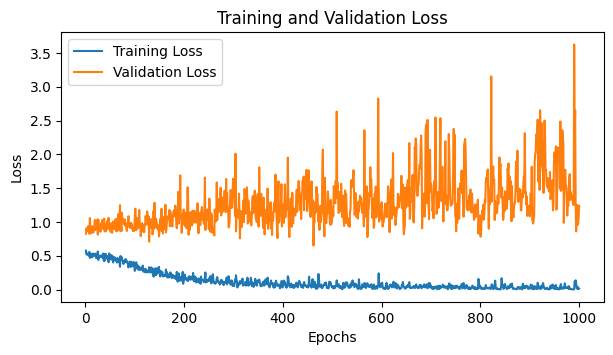

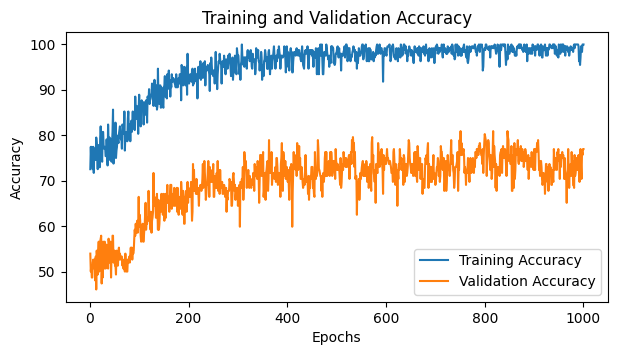

In [102]:
#plot the curves

# Create x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot the training and validation loss
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["loss"], label='Training Loss')
plt.plot(epochs, val_logs["loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(7, 3.5))
plt.plot(epochs, trg_logs["acc"], label='Training Accuracy')
plt.plot(epochs, val_logs["acc"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# save model
save_path="ants_bees_resnet18.pth"
torch.save(model.state_dict(),save_path)

In [ ]:
# load model
# Load the saved model
model_path="ants_bees_resnet18.pth"

model = CustomModel()  # Instantiate the model
model.load_state_dict(torch.load(model_path))

In [21]:
w=model.state_dict()

The model.state_dict() method in PyTorch returns a dictionary object that maps each parameter name to its corresponding value. You can access the information in the state_dict() using standard dictionary operations.

Here's an example of how to access the information in the state_dict():
#Get the model's state dictionary
state_dict = model.state_dict()

#Access specific parameter values
weights = state_dict['linear.weight']
bias = state_dict['linear.bias']

In this example, linear.weight and linear.bias are the names of specific parameters in your model. You can access other parameters in the same way by providing their respective names.

You can also iterate over the state_dict() to access all parameter names and values:
    
for name, value in state_dict.items():
    print(name, value.shape)

This will print the names of all parameters in the model along with their respective shapes.

Remember that the state_dict() only contains the learned parameters of the model and not other components like buffers or non-learnable parameters.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


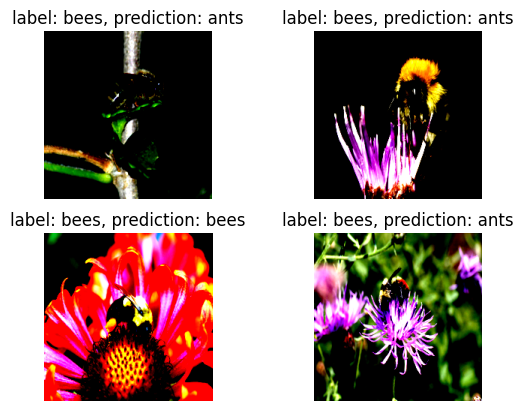

In [104]:
# make predictions

predict_val_dataloader=DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

val_iter=iter(predict_val_dataloader)
images,labels,class_names=next(val_iter)
images=images.to(device)
predictions=model(images)
predictions=nn.Sigmoid()(predictions)
# print(predictions)
predictions=[1 if x>=0.5 else 0 for x in predictions]
# print(predictions)
reverse_class_encoder={}
for k,v in train_data.class_encoder.items():
    reverse_class_encoder[v]=k
predicted_class_list=[reverse_class_encoder[num] for num in predictions]
# print(predicted_class_list)

for i in range(len(images)):
    plt.subplot(len(images)//2,len(images)//2,i+1)
    img=images[i]
    img=img.cpu().numpy()
    img=img.transpose(1,2,0)
    plt.imshow(img)
    plt.title(f"label: {class_names[i]}, prediction: {predicted_class_list[i]}")
    plt.axis("off")
    
    
plt.show()